In [1]:
%matplotlib inline
import sys
sys.path.append('../')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from modules.backtesting import Market, Trader
from modules.tools import open_file, product_info

In [2]:
feed = open_file('h5py', 'etc/ohlct.h5', mode='r')

In [3]:
def gen_signal(datatable):
    #추세지속일수
    days = 3
    
    Market.set_ATR(datatable, span=20)
    
    #추세 누적 지속일수
    down = up = neutral= 0
    for date, metric in datatable.iterrows():
        trend = metric['trend']
        if trend == 0:
            down += 1
            up = 0
            neutral = 0
        elif trend == 1:
            neutral += 1
            up = 0
            down = 0 
        elif trend == 2:
            up += 1
            down = 0
            neutral = 0
        datatable.loc[date, 'up'] = up
        datatable.loc[date, 'down'] = down
        datatable.loc[date, 'neutral'] = neutral

In [4]:
#market = Market(feed=feed)
market = Market(feed=feed, signal=gen_signal)

 preprocessing data...(61)          
Done


In [43]:
def strat(trader, inst, metric):
    date = metric.name
    symbol = inst['symbol']
    #entrylong
    if metric['up'] == 5:
        #if not trader.trades.isopen(info, Market.long, 'TF'):
        entryprice =  Market.get_price(inst, metric['open'], metric['high'], skid=0.25)
        position = Market.long
        stopprice = entryprice - metric['ATR']*5
        trader.buy(inst, 'TF', position, date, entryprice, stopprice)
    
    #entryshort
    if metric['down'] == 5:
        #if not trader.trades.isopen(info, Market.short, 'TF'):
        entryprice =  Market.get_price(inst, metric['open'], metric['low'], skid=0.25)
        position = Market.short
        stopprice = entryprice + metric['ATR']*5
        #stopprice = trader.stop_rule(info, position, metric, entryprice)
        trader.buy(inst, 'TF', position, date, entryprice, stopprice)
    
    #exit
    if (metric['neutral'] == 3):
        #exitlong
        trade = trader.trades.get(inst,'TF',Market.long)
        if trade:
            exitprice = Market.get_price(inst, metric['open'], metric['low'], skid=0.25)
            trader.sell(trade, date, exitprice)
            
        #exitshort
        trade = trader.trades.get(inst,'TF',Market.short)
        if trade:
            exitprice = Market.get_price(inst, metric['open'], metric['high'], skid=0.25)
            trader.sell(trade, date, exitprice)


In [21]:
def stop(self, trade, metric):
    #초기 설정
    stopprice = metric['close'] - trade['position']*metric['ATR']*5
    if trade['position']*(stopprice - trade['stopprice']) < 0:
        return trade['stopprice']
    else:
        return stopprice

In [44]:
%%time
trader = Trader(market=market,
                principal=100000,
                portfolio_heat=0.4,
                sector_heat=0.2,
                heat=0.05,
                max_lot= 5,
                strategy=strat,
                stop=stop)
trader.run_trade(start='2006-01-01', end='2017-01-01')

 now trading at 2014-12-31 00:00:00         Wall time: 3min 15s


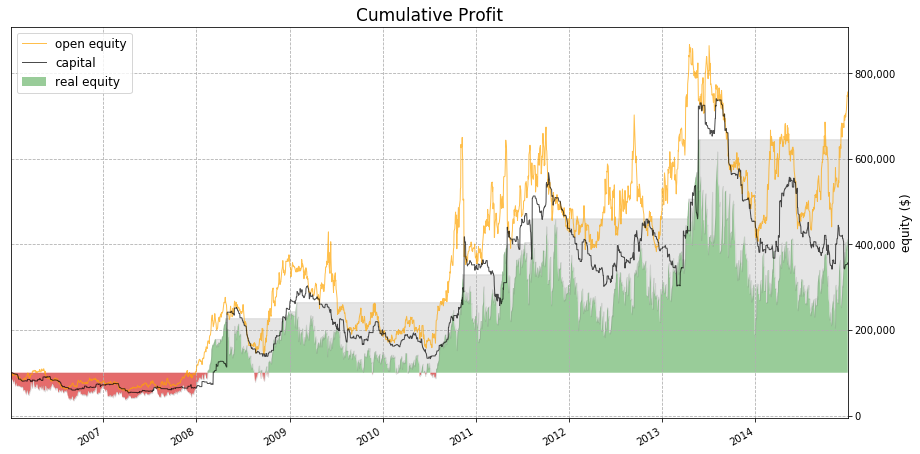

,투자금,최종자산,총손익,Bliss,ICAGR,MDD,손익비,승률,위험대비손익,평균손익,손익표준편차,보유기간,# trades
Total,"100,000","412,491",312.49%,0.223,15.76%,70.78%,1.07,43.15%,6.72%,151,"8,657",26 days,220.0
Long,,,,,,,1.18,44.82%,11.76%,409,"9,447",29 days,125.5
Short,,,,,,,0.91,40.94%,0.03%,-193,"7,472",23 days,94.5


In [42]:
trader.summary(level=0)

In [35]:
trader.summary(level=1)

,총손익(틱),평균손익(틱),표준편차(틱),위험대비손익,승률,매수평균(틱),매도평균(틱),Period(L),Period(S),# trades
Currency,6888,23.35,496.68,7.25%,43.39%,21.72,25.60,31 days,29 days,36.9
Equity,-6676,-65.45,385.51,-4.95%,39.22%,-47.78,-107.87,43 days,26 days,34.0
Fiber,5492,112.08,891.27,9.14%,46.94%,246.81,11.04,34 days,29 days,49.0
Grain,8162,29.05,341.84,17.03%,41.64%,73.50,-13.85,38 days,31 days,40.1
Meat,-3823,-36.41,169.75,-9.21%,37.14%,-40.19,-33.34,32 days,27 days,52.5
Metal,4988,40.55,692.34,17.92%,49.59%,72.38,-4.37,32 days,29 days,24.6
Petroleum,12770,119.35,945.95,11.74%,42.06%,28.06,260.62,35 days,48 days,17.8
Rate,12375,31.25,171.88,11.74%,49.75%,58.71,-26.24,49 days,28 days,44.0
Tropical,-3536,-22.67,237.13,-3.41%,38.46%,-19.66,-26.36,33 days,26 days,39.0


In [36]:
trader.summary(level=2)

,총손익(틱),평균손익(틱),표준편차(틱),위험대비손익,승률,매수평균(틱),매도평균(틱),Period(L),Period(S),# trades
10Year U.S. T-Note,532,10.86,116.93,9.02%,48.98%,21.64,-11.38,35 days,28 days,49.0
2Year U.S.T-Note,854,18.17,85.41,12.51%,44.68%,36.71,-17.75,49 days,25 days,47.0
30Year U.S. T-Bond,535,16.72,95.96,9.10%,53.12%,0.27,52.90,38 days,33 days,32.0
5Year U.S. T-Note,2157,50.16,215.49,18.41%,46.51%,82.70,-24.92,37 days,19 days,43.0
Australian Dollar,3289,86.55,289.39,23.03%,55.26%,103.65,49.50,47 days,29 days,38.0
British Pound,542,14.26,382.37,0.27%,42.11%,8.62,23.93,25 days,21 days,38.0
Canadian Dollar,-1920,-49.23,333.27,-4.89%,41.03%,-41.00,-57.89,24 days,20 days,39.0
Copper,-1225,-47.12,321.60,-7.03%,38.46%,-31.71,-65.08,32 days,29 days,26.0
Corn,-538,-13.12,168.66,1.00%,31.71%,-3.00,-23.75,37 days,26 days,41.0
Crude Oil (WTI),-1209,-63.63,453.84,-4.89%,42.11%,-166.91,78.38,28 days,39 days,19.0


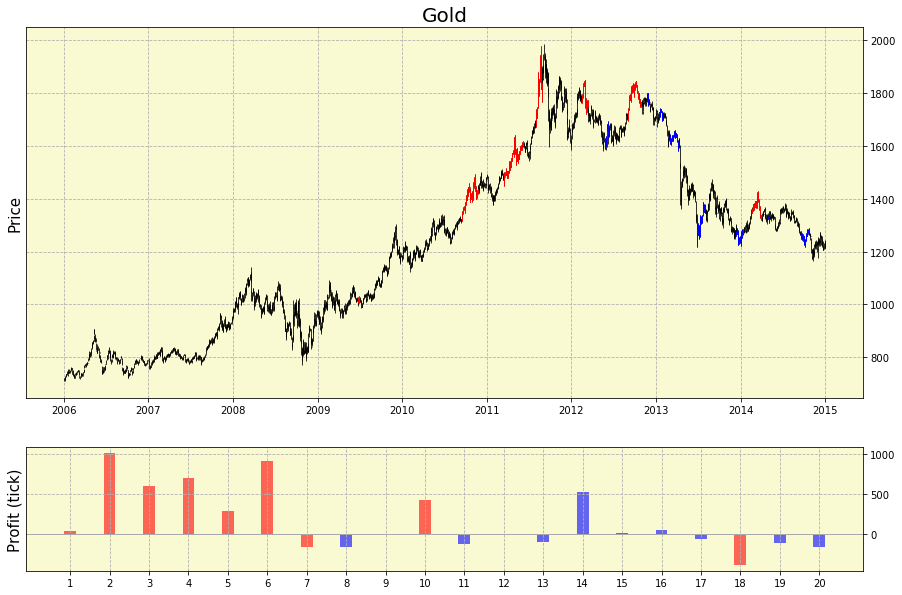

,id,sector,symbol,name,position,entrydate,entryprice,stopprice,entrylot,exitdate,exitprice,exitlot,force,risk,profit,tick,strat
0,460,Metal,GC,Gold,Long,2009-06-24,1013.7,938.073885,1,2009-06-30,1017.000000,1,False,9046.540606,330.0,33.0,TF
1,681,Metal,GC,Gold,Long,2010-09-14,1325.1,1364.461188,1,2010-11-22,1426.300000,1,False,7725.829109,10120.0,1012.0,TF
2,790,Metal,GC,Gold,Long,2011-03-14,1492.2,1457.483139,1,2011-04-18,1551.400000,1,False,9515.075363,5920.0,592.0,TF
3,809,Metal,GC,Gold,Long,2011-04-12,1531.9,1524.876825,1,2011-05-31,1601.600000,1,False,9554.750661,6970.0,697.0,TF
4,815,Metal,GC,Gold,Long,2011-04-27,1578.8,1524.876825,1,2011-06-07,1607.800000,1,False,9185.155090,2900.0,290.0,TF
5,865,Metal,GC,Gold,Long,2011-08-01,1687.9,1779.537991,2,2011-08-25,1779.537991,2,True,21018.643822,18320.0,916.0,TF
6,973,Metal,GC,Gold,Long,2012-02-14,1782.3,1708.749179,1,2012-03-12,1766.200000,1,False,14740.630502,-1610.0,-161.0,TF
7,1031,Metal,GC,Gold,Short,2012-05-23,1613.4,1735.358263,2,2012-05-29,1630.200000,2,False,26511.652698,-3360.0,-168.0,TF
8,1040,Metal,GC,Gold,Short,2012-06-04,1674.8,1812.967186,1,2012-06-07,1675.900000,1,False,14798.554484,-110.0,-11.0,TF
9,1085,Metal,GC,Gold,Long,2012-08-31,1714.7,1736.551324,2,2012-10-26,1756.900000,2,False,21713.889115,8440.0,422.0,TF


In [39]:
trader.report('GC')